In [1]:
# Imports needed for this exercice 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hcipy as hc # get at  https://docs.hcipy.org/0.4.0/

In this homework we will try to align two images using all sorts of techniques. This is a very simple problem (image registration) that has kept people up for years and that involves a series of Fourier manipulations. The aim of this hokwork is two fold:
- have you pratcice various Fourier manipulations
- learn a useful tool that might  help you in your research down the line. 

We are going to try to reproduce the main points from the following paper:
https://www.osapublishing.org/ol/viewmedia.cfm?uri=ol-33-2-156&seq=0
If you google it you will see that this paper has been cited 1500+ times since 2008. Interrestingly the concepts involved are very basic but it took a while for folks to piece this togther. 

## Sample images we will use

We work with two "apertures" that this time are shifted on with respect to another. For now we are using array that are 100 pixelx across. You can play with this value later on in the homework.

number of pixels in aperture array = 100
diameter of the physical array = 1


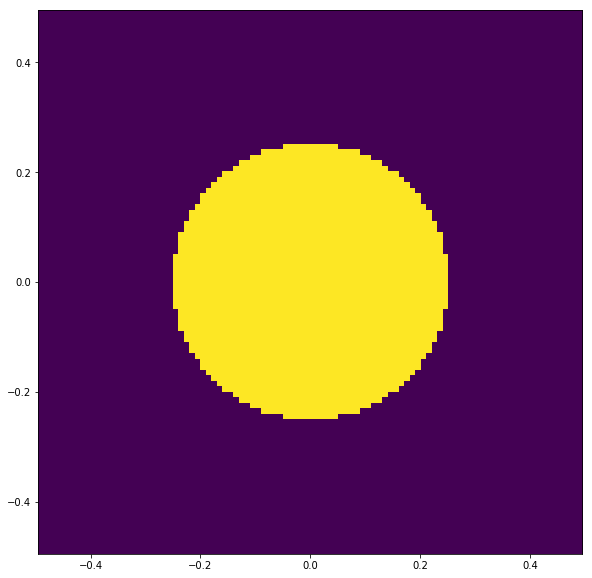

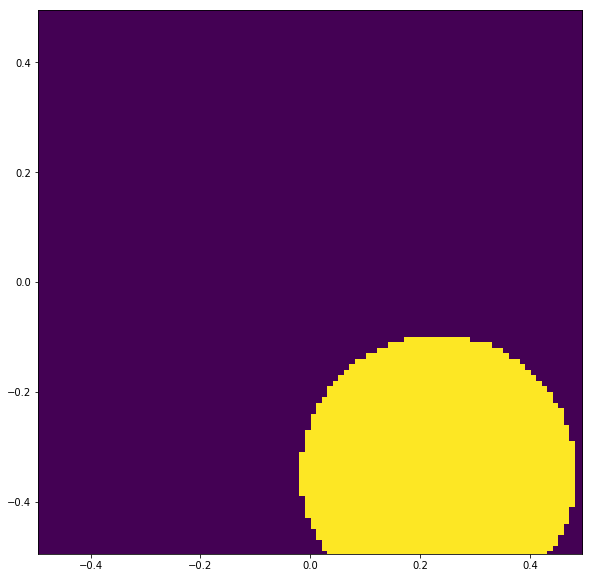

In [4]:
Npup = 100
print('number of pixels in aperture array = ' + str(Npup))
Diam = 1
print('diameter of the physical array = ' + str(Diam))
pupil_grid = hc.field.make_pupil_grid(Npup, diameter=1.)
circular_aperture_object_1 =  hc.aperture.circular_aperture(0.5, center=[0,0]) # We use the center option to create the apertures
circular_aperture_field_1 = circular_aperture_object_1(pupil_grid)
ShiftX =0.232
ShiftY = -0.347
circular_aperture_object_2 =  hc.aperture.circular_aperture(0.5, center=[ShiftX,ShiftY])
circular_aperture_field_2 = circular_aperture_object_2(pupil_grid)
fig = plt.figure(figsize = [10,10])
hc.imshow_field(circular_aperture_field_1)
fig = plt.figure(figsize = [10,10])
hc.imshow_field(circular_aperture_field_2)

# Calculate convolution  brute force style

Here we calclualte the correlation/convolution using brute force. Whatever imgae shift this convolution is maximun corresponds to the relative shift between the two input images 
We switch the center of the images using the numpy roll function (only allows for integer pixel moves). 

In [5]:
convolution=np.zeros([np.divmod(Npup,1)[0],np.divmod(Npup,1)[0]]) 
for pp in range(0,np.divmod(Npup,1)[0],1):
    for qq in range(0,np.divmod(Npup,1)[0],1):
        tmp0 = np.roll(np.reshape(circular_aperture_field_1,[Npup,Npup]),(pp-np.divmod(Npup,2)[0],qq-np.divmod(Npup,2)[0]),axis=(0,1))
        tmp1 = np.reshape(tmp0,Npup*Npup)
        tmp2 = circular_aperture_field_2
        tmp3 = np.sum(tmp1*tmp2)
        tmp4 = np.sqrt(np.sum(tmp1**2))
        tmp5 = np.sqrt(np.sum(tmp2**2))
        convolution[pp,qq] = tmp3/tmp4/tmp5 

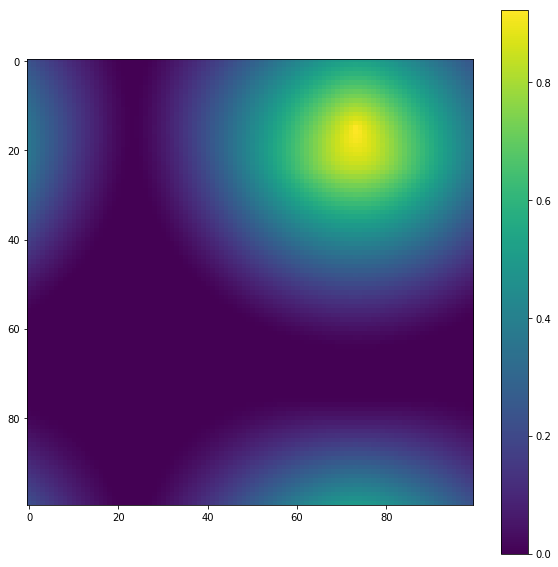

In [6]:
fig = plt.figure(figsize = [10,10])
plt.imshow(convolution)
plt.colorbar()

Q1: Why do we have these weird "echos" on the side of the correlation map? Would changing the aperture size make them disapear?


Q2:  Evalute the relative shift between the images by using a look up table, based on the code use to calcuate the correlation map, to figure out the coordinates of the maximum of the correlation. 


Q3: Clearly the shift is not measured with enough significant digits (here 1/10 th of a pixel is 0.001, since one pixels is 0.01 with Diam = and Npup = 100). How would you do that? Either increase the number of pixels in the image, or use some interpolation functions to carry out sub-pixels shifts is the loop. For both methods, discuss how the calcuation time would scale. You can either get to the answer using order of magnitude pen and paper, or try different values of Npup and non integer pixel shifts (warning, using large Npup will be quickly unforgiving) and empirically time the calculations.

# Calcualte convolution with FFT

Q4: using the concepts discussed in class and the HCIPy decalration of FFT below, generate the same correlation map using FFTs.  

In [8]:
q0 = 2.
FFT = hc.fourier.FastFourierTransform(pupil_grid, q=q0, fov=1, shift=0, emulate_fftshifts=None)

Q5: based on this correlation map calcuate the shift betwen the two images (you can shamelessly use pupil_grid.x and y as coordinate system)

Q6: based on these shifts and the fourier shift theorem, re-align circular_aperture_field_2 with respect to circular_aperture_field_1 using FFTs

Q7: Again discuss how you could get sub-pixel precision using FFT? Try to change q0 and see if it changes the results.  You do not have to write code for this as the answer is not straighforward. 

# Calcualte convolution with MFT

Q8: We want to have a precision of 1/10 of a pixel. And we are going to do this with MFTs. By now you should be familiar with the trick: take FT of the two images, complex conjugate one of them, multiply, and take inverse FT. Do this with MFTs using pupil_grid. We recall that this is how they are defined in HCIpy: 

In [9]:
q = 2.
num_airy = Npup/2
num_airy_two_pi = 2*np.pi*num_airy
focal_grid = hc.field.make_focal_grid(q, num_airy_two_pi)
MFT = hc.fourier.MatrixFourierTransform(pupil_grid,focal_grid, precompute_matrices=None, allocate_intermediate=None)

Q9: Here we create a pupil grid using sub_pixel_sampling = 10 that is ten times denser. Use that pupil grid to get  sub pixel registration at the 1/10 th or a pixel level. 

Q10: based on this correlation map calcuate the shift betwen the two images (you can shamelessly use pupil_grid.x and y as coordinate system)

Q11: based on these shifts and the fourier shift theorem, re-align circular_aperture_field_2 with respect to circular_aperture_field_1 using MFTs. Try to change num_airy. Would this step best done with FFT?

Q12: Discuss numerical scaling of this algorithm with respet to Npup and precision of the sub pixel sampling. 

# More in depth work

None of the correlation methods here are automatically propertly normalized (eg max of correlation = 1 when images are aligned). You could try to do that the right way. 

Based on your answers to all the questions and your understanding of the paper, what is the optimal combination of FFTs and MFTs for that give best percision while scaling well numerically? Try to write it in pseudo code. You can find exmaple python code for this as https://image-registration.readthedocs.io/en/latest/_modules/image_registration/register_images.html

This algorithm is also part of the popular scikit-image package https://scikit-image.org/ [see following example https://scikit-image.org/docs/dev/auto_examples/registration/plot_register_translation.html], you can pick you favorite datasets from your favorite project and try to apply these methods to them. If you are successful you can forget everything about "what s in the box" from this assignment and just used these pre canned and stable functions.  